In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import torch.optim as optim
import torch.nn.functional as F
import time
import random

c:\Users\Dell\Desktop\projects\pytorch_projects\.nvenv\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Dell\Desktop\projects\pytorch_projects\.nvenv\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Dell\Desktop\projects\pytorch_projects\.nvenv\Lib\site-packages\torchtext\data\__i

In [2]:
RANDOM_SEED=42
MAX_VOCAB=20000
LEARNING_RATE=0.005
BATCH_SIZE=128
EMBEDDING_DIM=128
HIDDEN_DIM=256
OUTPUT_DIM=1
NUM_EPOCHS=25
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Dell\Desktop\projects\pytorch_projects\.nvenv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Dell\Desktop\projects\pytorch_projects\.nvenv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Dell\Desktop\projects\pytorch_projects\.nvenv\Lib\site-packages\ipykernel\kernelapp.py", 

In [3]:
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [4]:
tokenizer=get_tokenizer('spacy',language='en_core_web_sm')

In [5]:
def yeild_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [6]:
class IMDBCSVDataset(Dataset):
    def __init__(self,csv_file):
        self.data=pd.read_csv(csv_file)
        self.data['sentiment'] = self.data['sentiment'].map({'positive': 1, 'negative': 0})
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        review = self.data.iloc[idx]['review']
        sentiment = self.data.iloc[idx]['sentiment']
        return sentiment, review

In [7]:
dataset=IMDBCSVDataset('data/IMDB Dataset.csv')
train_dataset,test_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset, [0.85,0.15])

In [8]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 34000
Number of validation examples: 6000
Number of testing examples: 10000


In [9]:
vocab=build_vocab_from_iterator(yeild_tokens(train_dataset),max_tokens=MAX_VOCAB,specials=['<unk>','<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [10]:
def text_pipeline(x):
    tokens=tokenizer(x)
    indexed_tokens=[vocab[token] for token in tokens]
    return torch.tensor(indexed_tokens,dtype=torch.long)
def label_pipeline(x):
    return torch.tensor(x,dtype=torch.long)
def collate_batch(batch):
    text_list=[]
    label_list=[]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = text_pipeline(_text)
        text_list.append(processed_text)
    padded_texts = pad_sequence(text_list, batch_first=True, padding_value=vocab['<pad>'])
    return padded_texts, torch.tensor(label_list,dtype=torch.long)

In [11]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_batch)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_batch)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_batch)

In [12]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        hidden = hidden[-1]

        out = self.fc(hidden)

        return out

In [13]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features).squeeze(-1)
            predicted = (torch.sigmoid(outputs) > 0.5).long()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    return correct_predictions * 100.00 / total_predictions

In [14]:
model = RNN(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [15]:
start=time.time()
patience=5
train_accs=[]
val_accs=[]
for epoch in range(NUM_EPOCHS):
    model.train()
    for i,(features,labels) in enumerate(train_loader):
        features=features.to(DEVICE)
        labels=labels.to(DEVICE).float()
        optimizer.zero_grad()
        outputs=model(features).squeeze(-1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_acc=compute_accuracy(model,train_loader,DEVICE)
        val_acc=compute_accuracy(model,val_loader,DEVICE)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')
        
    if epoch > 1:
        if val_accs[-1] < val_accs[-2]:
            patience -= 1
        else:
            patience = 5
    
    if patience == 0:
        print(" ! ! Stopping early ! ! ")
        break
    
    print(f'Time elapsed: {time.time()-start:.2f} seconds')


print('Test Accuracy: {:.2f}%'.format(compute_accuracy(model,test_loader,DEVICE)))

Epoch: 1, Loss: 0.3703, Train Accuracy: 87.11%, Validation Accuracy: 85.20%
Time elapsed: 292.80 seconds
Epoch: 2, Loss: 0.3122, Train Accuracy: 93.39%, Validation Accuracy: 88.05%
Time elapsed: 569.14 seconds
Epoch: 3, Loss: 0.2080, Train Accuracy: 96.19%, Validation Accuracy: 89.25%
Time elapsed: 855.14 seconds
Epoch: 4, Loss: 0.0875, Train Accuracy: 98.61%, Validation Accuracy: 89.10%
Time elapsed: 1138.07 seconds
Epoch: 5, Loss: 0.0316, Train Accuracy: 99.09%, Validation Accuracy: 89.10%
Time elapsed: 1413.35 seconds
Epoch: 6, Loss: 0.0252, Train Accuracy: 99.46%, Validation Accuracy: 89.20%
Time elapsed: 1689.84 seconds
Epoch: 7, Loss: 0.0218, Train Accuracy: 99.28%, Validation Accuracy: 88.38%
Time elapsed: 1974.18 seconds
Epoch: 8, Loss: 0.0160, Train Accuracy: 99.22%, Validation Accuracy: 88.65%
Time elapsed: 2255.23 seconds
Epoch: 9, Loss: 0.0094, Train Accuracy: 99.47%, Validation Accuracy: 88.48%
Time elapsed: 2530.77 seconds


KeyboardInterrupt: 

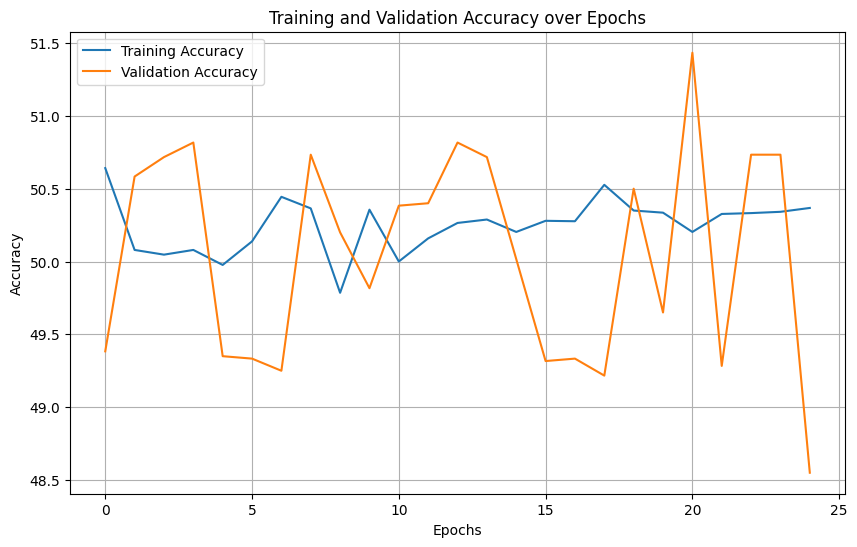

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot( train_accs, label='Training Accuracy')
plt.plot( val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
import numpy as np

y_pred = []
y_true = []
y_prob = []

model.eval()
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(DEVICE)
        labels = labels.to(DEVICE)
        
        logits = model(texts).squeeze(-1)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(labels.cpu().tolist())
        y_prob.extend(probs.cpu().tolist())

# Convert to numpy arrays at the end
y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_prob = np.array(y_prob)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_prob)

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")

Accuracy  : 0.4969
Precision : 0.5006
Recall    : 0.4644
F1-score  : 0.4818
ROC-AUC   : 0.4970


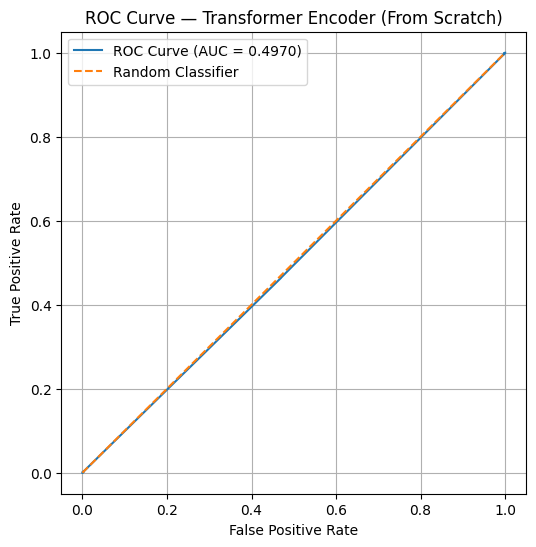

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Transformer Encoder (From Scratch)')
plt.legend()
plt.grid(True)
plt.show()